In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from scipy.optimize import curve_fit
from scipy.stats import norm

## Alpha Persei

In [2]:
query='''
SELECT top 100000 source_id,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra,pmdec
FROM gaiadr3.gaia_source
WHERE ra BETWEEN 50 AND 53 AND
dec BETWEEN 47 AND 50
AND parallax IS NOT NULL
ORDER BY parallax DESC
'''
job=Gaia.launch_job_async(query)
r=job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
# Pick stars close to the overdensity

filter_up= r['parallax']>4.8
filter_down=r['parallax']<8
filtered=np.logical_and(filter_up,filter_down)
r_filtered=r[filtered]

distance_filtered=1/r_filtered['parallax']
n,bins=np.histogram(distance_filtered,bins=100)

x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)
    

def gaussian(x,disp,amp,mu,sigma):
    return disp+amp*norm.pdf(x,mu,sigma)
    
popt,pcov=curve_fit(gaussian,x_array,n,p0=(0,20,0.18,0.1))

# Retain stars within 3*stdev to pick stars from the cluster
distance=popt[2]
std=popt[3]
filter2_up=r_filtered['parallax']<1/(distance-3*std)
filter2_down=r_filtered['parallax']>1/(distance+3*std)
filter2=np.logical_and(filter2_up,filter2_down)
data_alphapersei=r_filtered[filter2]

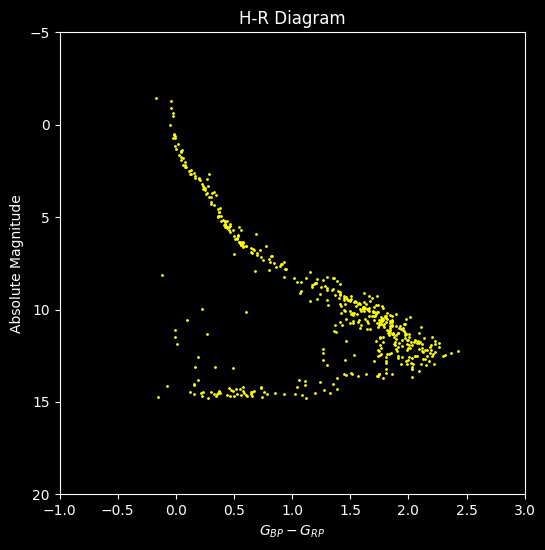

In [4]:
abs_mag=(data_alphapersei['phot_g_mean_mag']-5*np.log10(100/(data_alphapersei['parallax'])))      
xaxis=data_alphapersei['phot_bp_mean_mag']-data_alphapersei['phot_g_mean_mag']

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.scatter(xaxis,abs_mag,color='yellow',s=1)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

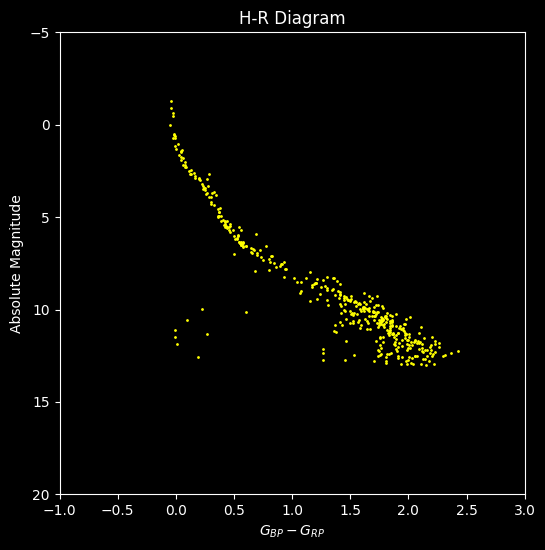

In [5]:
# Remove relics of poor photometry at the bottom
mask=abs_mag<13
abs_mag=abs_mag[mask]
xaxis=xaxis[mask]

mask2=xaxis>-0.1
abs_mag=abs_mag[mask2]
xaxis=xaxis[mask2]

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.scatter(xaxis,abs_mag,color='yellow',s=1)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('H-R Diagram')
plt.show()

## Isochrone Fitting

In [6]:
# Load isochrone data corresponding to 100 million years
from astropy.io import ascii
isodata=ascii.read('isochronedata.txt',delimiter=' ')
isodata

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0152,0.01508,8.0,0.0900000036,1.0816895926,0.09,-2.755,3.4013,4.705,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.31e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.658,13.705,16.472,12.229
0.0152,0.01508,8.0,0.0931723565,1.1114012737,0.093,-2.73,3.4048,4.708,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.44e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.594,13.642,16.41,12.165
0.0152,0.01508,8.0,0.1000000015,1.1711064122,0.1,-2.675,3.4126,4.715,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.73e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.457,13.504,16.274,12.028
0.0152,0.01508,8.0,0.1009420455,1.1789277777,0.101,-2.668,3.4135,4.716,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.77e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.441,13.488,16.258,12.011
0.0152,0.01508,8.0,0.1116045266,1.2613248813,0.112,-2.593,3.4232,4.724,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.22e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.254,13.216,15.878,11.759
0.0152,0.01508,8.0,0.1200000122,1.3193155232,0.12,-2.538,3.431,4.731,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.58e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.116,12.964,15.483,11.533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0152,0.01508,8.0,5.31620121,2.6155892128,2.684,4.429,3.4451,-0.83,8,0.921,0.094,636.87,-1.0,-1.0,-1.0,-1.0,1,-7.99e-05,4.72,0.6111,0.3731,0.0003694,0.005103,0.005262,-1.0,0.01579,-6.303,4.243,11.29,1.94
0.0152,0.01508,8.0,5.3162107468,2.6155892556,2.633,4.449,3.4407,-0.875,8,0.922,0.095,630.77,-1.0,-1.0,-1.0,-1.0,1,-0.000105,6.04,0.611,0.3732,0.0003732,0.005103,0.005262,-1.0,0.0158,-6.352,6.084,13.992,3.642


In [7]:
# Remove irrelevant red giants
isodata=isodata[isodata['logg']>3]
isodata

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0152,0.01508,8.0,0.0900000036,1.0816895926,0.09,-2.755,3.4013,4.705,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.31e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.658,13.705,16.472,12.229
0.0152,0.01508,8.0,0.0931723565,1.1114012737,0.093,-2.73,3.4048,4.708,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.44e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.594,13.642,16.41,12.165
0.0152,0.01508,8.0,0.1000000015,1.1711064122,0.1,-2.675,3.4126,4.715,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.73e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.457,13.504,16.274,12.028
0.0152,0.01508,8.0,0.1009420455,1.1789277777,0.101,-2.668,3.4135,4.716,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.77e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.441,13.488,16.258,12.011
0.0152,0.01508,8.0,0.1116045266,1.2613248813,0.112,-2.593,3.4232,4.724,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.22e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.254,13.216,15.878,11.759
0.0152,0.01508,8.0,0.1200000122,1.3193155232,0.12,-2.538,3.431,4.731,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.58e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,11.116,12.964,15.483,11.533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0152,0.01508,8.0,5.0755376816,2.6144502203,5.075,3.21,4.0969,3.273,2,0.0,0.538,0.0,0.0,0.0,0.0,0.0,-1,-1e-30,0.0,0.7092,0.2755,0.00271,0.0007399,0.00672,-1.0,0.01527,-3.255,-2.569,-2.62,-2.479
0.0152,0.01508,8.0,5.0757651329,2.6144513555,5.075,3.216,4.085,3.219,2,0.0,0.538,0.0,0.0,0.0,0.0,0.0,-1,-1e-30,0.0,0.7092,0.2755,0.00271,0.0007399,0.00672,-1.0,0.01527,-3.27,-2.647,-2.694,-2.565


In [8]:
#Removing datapoints beyond xlim,ylim
isodata=isodata[isodata['G_BPmag']-isodata['G_RPmag']>-1]
isodata=isodata[isodata['G_BPmag']-isodata['G_RPmag']<3]
isodata['model_x']=isodata['G_BPmag']-isodata['G_RPmag']
isodata['model_y']=isodata['Gmag']
isodata

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag,model_x,model_y
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0152,0.01508,8.0,0.25,1.8403257998,0.25,-2.035,3.4867,4.77,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-9.68e-16,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,9.858,11.043,12.748,9.792,2.9559999999999995,11.043
0.0152,0.01508,8.0,0.2923896313,1.9374168521,0.292,-1.928,3.4967,4.771,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.14e-15,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,9.59,10.68,12.27,9.461,2.8089999999999993,10.68
0.0152,0.01508,8.0,0.3000000119,1.9529139769,0.3,-1.91,3.4984,4.771,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.18e-15,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,9.546,10.621,12.194,9.407,2.787000000000001,10.621
0.0152,0.01508,8.0,0.3500000238,2.0434175133,0.35,-1.796,3.5087,4.765,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.43e-15,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,9.26,10.25,11.724,9.067,2.657,10.25
0.0152,0.01508,8.0,0.4000000358,2.118502481,0.4,-1.681,3.5194,4.75,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.77e-15,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,8.972,9.879,11.259,8.727,2.532,9.879
0.0152,0.01508,8.0,0.4500000477,2.1822809714,0.45,-1.558,3.5314,4.727,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-2.26e-15,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,8.666,9.488,10.773,8.371,2.4019999999999992,9.488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0152,0.01508,8.0,5.0755376816,2.6144502203,5.075,3.21,4.0969,3.273,2,0.0,0.538,0.0,0.0,0.0,0.0,0.0,-1,-1e-30,0.0,0.7092,0.2755,0.00271,0.0007399,0.00672,-1.0,0.01527,-3.255,-2.569,-2.62,-2.479,-0.14100000000000001,-2.569
0.0152,0.01508,8.0,5.0757651329,2.6144513555,5.075,3.216,4.085,3.219,2,0.0,0.538,0.0,0.0,0.0,0.0,0.0,-1,-1e-30,0.0,0.7092,0.2755,0.00271,0.0007399,0.00672,-1.0,0.01527,-3.27,-2.647,-2.694,-2.565,-0.129,-2.647


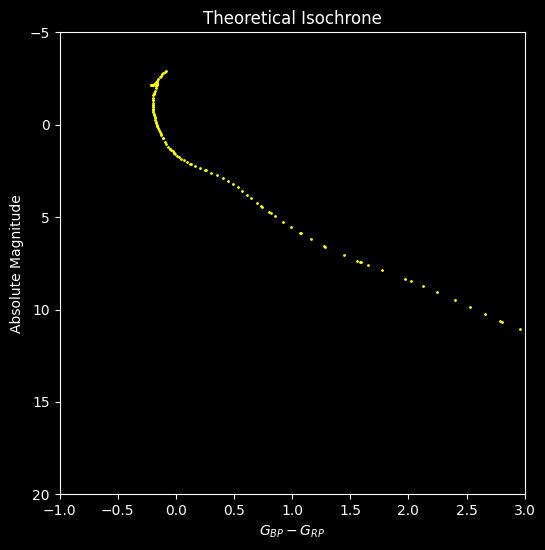

In [9]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.scatter(isodata['model_x'],isodata['model_y'],color='yellow',s=1)
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.title('Theoretical Isochrone')
plt.show()

In [10]:
#Picking nearest neighbour to data on the isochrone
def nearestNeighbour(isodata,xaxis,abs_mag):
    nbrs=[]
    mass_estimates=[]
    for i in range(len(xaxis)):
        distance=np.inf
        for j in range(len(isodata)):
            calc=np.sqrt(np.power((np.float64(xaxis[i])-isodata['model_x'][j]),2)+np.power((abs_mag[i]-isodata['model_y'][j]),2))
            if calc<distance:
                distance=calc
                nearest=j
        nbrs.append(nearest)
        mass_estimates.append(isodata['Mini'][nearest])
    return nbrs,mass_estimates

nearest_Neighbour,mass_estimates = nearestNeighbour(isodata,xaxis,abs_mag)              

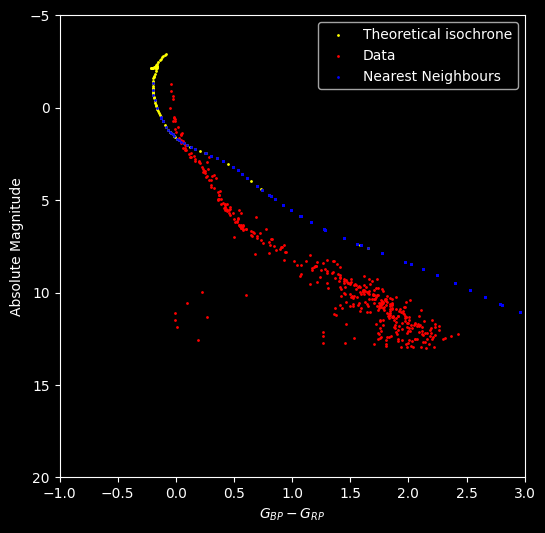

In [11]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.scatter(isodata['model_x'],isodata['model_y'],color='yellow',s=1,label='Theoretical isochrone')
    plt.scatter(xaxis,abs_mag,color='red',s=1,label='Data')
    plt.scatter(isodata['model_x'][nearest_Neighbour],isodata['model_y'][nearest_Neighbour],s=1,color='blue',label='Nearest Neighbours')
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylim(20,-5)
    plt.gca().invert_yaxis
    plt.xlim(-1,3)
    plt.ylabel('Absolute Magnitude')
    plt.legend()
    plt.show()

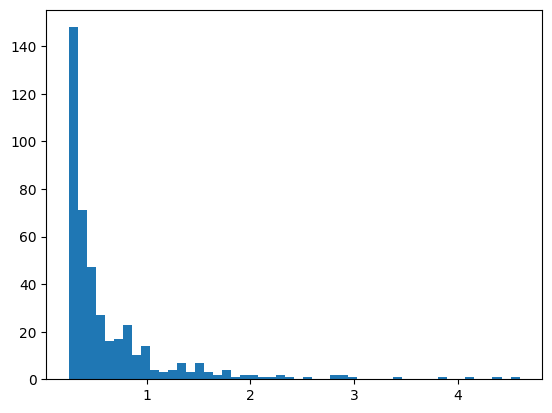

In [12]:
counts,bins=np.histogram(mass_estimates,bins=50)
plt.hist(mass_estimates,bins=50)
plt.show()

In [13]:
x_array=[]
for i in range(len(bins)-1):
    x_array.append((bins[i]+bins[i+1])/2)

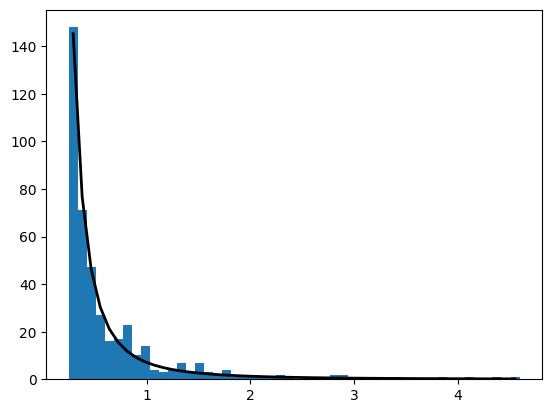

In [14]:
def power_law(m,gamma,k):
    return k*m**(-gamma)

popt,pcov=curve_fit(power_law,x_array,counts)

plt.plot(x_array,power_law(x_array,popt[0],popt[1]),linewidth=2,color='black')
plt.hist(mass_estimates,bins=50)
plt.show()

In [15]:
popt

array([2.46384617, 7.0830717 ])

## Empirical Initial Mass Function

$N=7\left[\frac{M}{M_{\odot}}\right]^{-2.46}$

Exponent in Salpeter's IMF: -2.35